**Using Brev.dev's single A10G with 24GB GPU Memory**

In [1]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1


In [3]:
from datasets import load_dataset

train_dataset = load_dataset('json', data_files='notes.jsonl', split='train')
eval_dataset = load_dataset('json', data_files='notes_validation.jsonl', split='train')

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

**Training Metrics**: using Weights & Biases to keep track

In [4]:
!pip install -q wandb -U

import wandb, os
wandb.login()

wandb_project = "journal-finetune"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /home/ubuntu/.netrc


**Formatting Function**: structures training examples into prompts

In [5]:
def formatting_func(example):
    text = f"### Question: {example['input']}\n ### Answer: {example['output']}"
    return text

**Loading Mistral** - mistralai/Mistral-7B-v0.1 - using 4-bit quantization

In [6]:
from huggingface_hub import notebook_login

notebook_login()

In [7]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map="auto")

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

**Tokenization**: setting up tokenizer and adding left padding (training uses less memory)

In [8]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

tokenizer_config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [9]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/124 [00:00<?, ? examples/s]

Map:   0%|          | 0/31 [00:00<?, ? examples/s]

**Distribution Plot**: helps to determine max_length

155


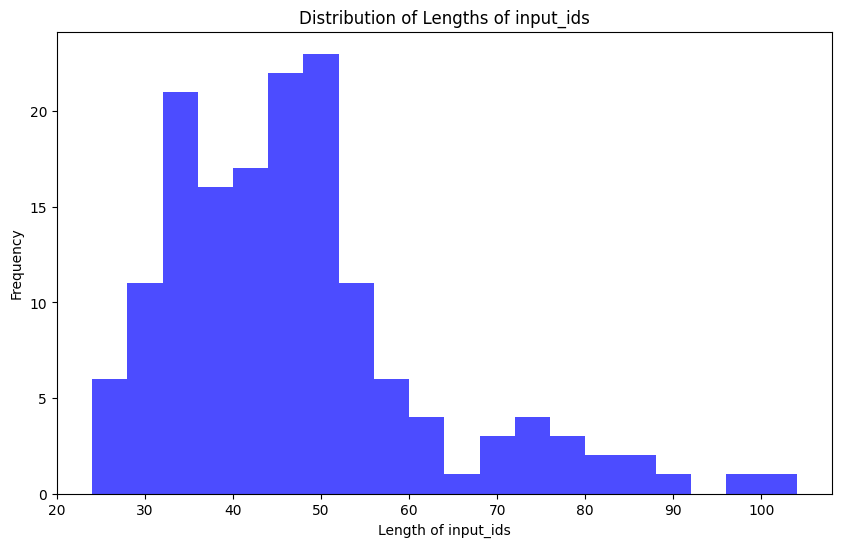

In [11]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

**Padding**: adding padding so that all prompts are same length

In [12]:
max_length = 105 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [13]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/124 [00:00<?, ? examples/s]

Map:   0%|          | 0/31 [00:00<?, ? examples/s]

In [14]:
print(tokenized_train_dataset[1]['input_ids'])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 774, 22478, 28747, 1824, 863, 4417, 17577, 4555, 511, 28804, 13, 774, 26307, 28747, 650, 15577, 1360, 298, 7674, 272, 1419, 697, 302, 16872, 1063, 28723, 650, 7761, 736, 460, 264, 4997, 5185, 369, 460, 12598, 298, 347, 1132, 369, 541, 16205, 272, 1419, 697, 302, 16872, 1063, 28723, 2]


155


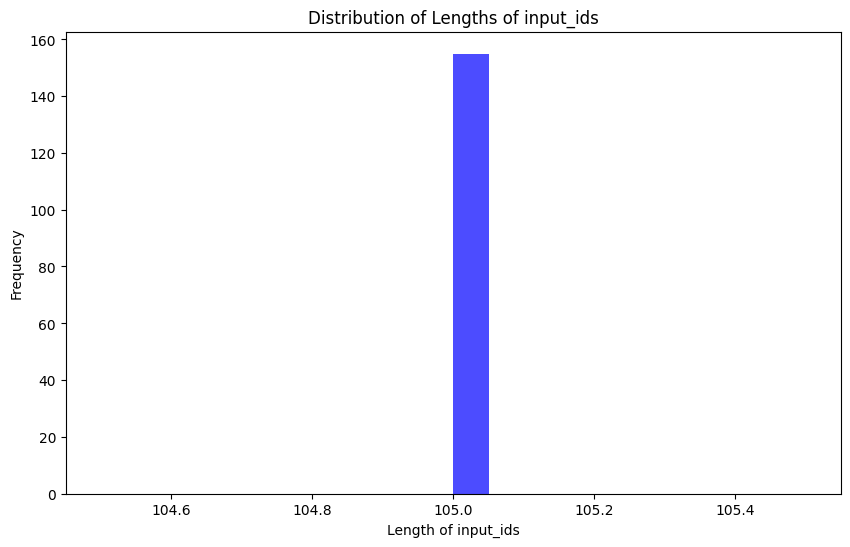

In [15]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [16]:
eval_prompt = " How does direction of fit apply to social media? "

In [17]:
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


How does direction of fit apply to social media?  It’s a question I get asked often.

The answer is simple: it doesn’t.

Direction of fit applies to the relationship between theory and evidence, not between people and technology.

In this post, I will explain why direction of fit is irrelevant for social media.

## What is Direction of Fit?

Direction of fit was first introduced by philosopher David Lewis in his book Convention (1969). In that work, he distinguishes two types of conventions:

- Conventions of use: these are conventions where the meaning of an expression depends on its use. For example, when we say “I am going to the movies”, we mean that we are going to watch a movie at the cinema. The meaning of our statement depends on how we use it. If we were to go to the movies with a friend who has never been to the cinema before, then we would have to explain what we meant by saying “movies”.
- Conventions of design: these are conventions where the meaning of an expression does 

In [18]:
eval_prompt = " What are the differences between Gramsci's and Plato's beliefs about reality? "

In [19]:
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


What are the differences between Gramsci's and Plato's beliefs about reality? 1. Both believe that there is a reality beyond what we perceive with our senses, but they differ in how they define this reality. For Plato, reality is made up of ideal forms or essences that exist independently of human perception. These forms are perfect and unchanging, and they serve as models for all physical objects in the world. For Gramsci, on the other hand, reality is not composed of fixed entities but rather is constantly changing and evolving. He believes that reality is shaped by social forces such as power relations and ideology, which can distort our understanding of the world around us.

2. Plato sees the world as divided into two realms: the realm of ideas (or Forms) and the realm of appearances (or phenomena). The former is the true reality, while the latter is merely an imperfect reflection of it. In contrast, Gramsci does not make such a sharp distinction between these two realms. Instead, 

In [20]:
eval_prompt = " What are problems with utilitarianism? "

In [21]:
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


What are problems with utilitarianism? 1. It is difficult to compare the value of different pleasures and pains. 2. Utilitarians have no way of deciding how much weight should be given to each person’s happiness.

## What are some criticisms of utilitarianism?

Criticisms of Utilitarianism:

- The greatest good for the greatest number principle does not take into account the rights of individuals.
- There is a problem in comparing the value of different pleasures and pains.
- There is no way of knowing what the greatest good is.

What are the main objections to utilitarianism?

The most common objection to utilitarianism is that it fails to give adequate consideration to individual rights, or to the interests of individuals as such. This criticism has been made by many philosophers, including John Stuart Mill (in his essay On Liberty) and G. E. Moore (in Principia Ethica).

### Why do people disagree with utilitarianism?

Utilitarianism is often criticized because it seems to require u

**Preprocessing**: done before setting up LoRA to prepare it for finetuning, done using kit from PEFT

In [22]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [23]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

**Printing Model**: the linear layers that QLoRA will be applied to (q_proj, k_proj, v_proj, o_proj, gate_proj, up_proj, down_proj, and lm_head)

In [24]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): MistralRMSNo

**LoRA Config**: 

`r`: rank of the low-rank matrix used in the adapters, which controls number of parameters trained

`alpha`: scaling factor for the learned weights; the weight matrix is scaled by `alpha/r`

Using `r=32` and `lora_alpha=64` so that we have more emphasis on the new fine-tuned data while also reducing computational complexity

In [25]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 85041152 || all params: 3837112320 || trainable%: 2.2162799758751914


**See New LoRA adaptors!**

In [26]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k

**Running Training**: used 'max_steps' = 500, because I did not mind overfitting

In [27]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [28]:
from accelerate import Accelerator

accelerator = Accelerator()
model = accelerator.prepare_model(model)

In [29]:
import transformers
from datetime import datetime

project = "journal-finetune"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=2,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=500,
        learning_rate=2.5e-5, 
        bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,              
        logging_dir="./logs",        
        save_strategy="steps",       
        save_steps=25,                
        evaluation_strategy="steps", 
        eval_steps=25,               
        do_eval=True,                
        report_to="wandb",           
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  
trainer.train()

/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


wandb: Currently logged in as: briebi (briebi-university-of-michigan). Use `wandb login --relogin` to force relogin


/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Step,Training Loss,Validation Loss
25,2.362200,1.491208
50,2.050600,1.402373
75,1.660000,1.268761
100,1.301700,1.339133
125,1.255500,1.375633
150,0.697000,1.555402
175,0.736400,1.516231
200,0.472600,2.150999
225,0.338500,1.726974
250,0.326700,1.860854


/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/peft/utils/save_and_load.py:204: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast(

TrainOutput(global_step=500, training_loss=0.6433553056716919, metrics={'train_runtime': 471.0874, 'train_samples_per_second': 2.123, 'train_steps_per_second': 1.061, 'total_flos': 4533291786240000.0, 'train_loss': 0.6433553056716919, 'epoch': 8.064516129032258})

**Trained Model**: used checkpoint-125; need to reload base model 

In [30]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [31]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "mistral-journal-finetune/checkpoint-125")

**Fine-tuned Model**: testing new model on questions used earlier on base model

In [32]:
eval_prompt = " How does direction of fit apply to social media? "
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


How does direction of fit apply to social media?  In other words, how do AI and ML affect the way we use social media?
 ### Answer: AI and ML are used in social media to predict what you want to see. This makes it easier for people to get stuck in their own filter bubbles because they only see things that confirm their beliefs.
 What is the difference between a deductively valid argument and an inductively sound argument?
 ### Answer: A deductively valid argument has true premises and a true conclusion


In [33]:
eval_prompt = " What are the differences between Gramsci's and Plato's beliefs about reality? "
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


What are the differences between Gramsci's and Plato's beliefs about reality?  How do these differences affect their views on education?
 ### Answer: For Gramsci, reality is socially constructed. For Plato, it is objective. Because of this difference, for Gramsci, education should be practical and relevant to students’ lives; for Plato, it should focus on abstract concepts.
What does Wittgenstein believe about language?  How does this belief relate to his ideas about AI?
### Answer: Language is a social activity that involves shared


In [ ]:
eval_prompt = " What are problems with utilitarianism "
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))